# Introduction

Many properties of materials, particularly nanomaterials are determined by their structure. The complete structure of a nanoparticle can be described by a point cloud of the atoms, however this has many variables and scales linearly with the number of atoms in the nanoparticle. This makes further analysis of a nanoparticle's properties very inneficient for larger nanoparticles if all atom's positions in the point cloud are used so a smaller feature set that describes important aspects of the structure can be very beneficial.

This program has been developed to extract structural properties from a point cloud of atoms (Generated by LAMMPS) representing a single nanoparticle.

The structural properties extracted are 

1. The total number of atoms (N_total)
2. The number of atoms in the outer shell/surface (N_shell). There are three choices when determining which atoms are in the outer shell that can be selected below, namely convex hull, number of neighbours or alpha shape.

Along with the minimum, maximum, mean, standard deviation, skew and kurtosis of the

1. Radius (R) relative to the centre of mass
2. Atomic coordination number (CN) (Number of neighbours for a given atom) 
3. Surface coordination number (SCN) (Number of neighbours for atom's on the surface)
4. Bond length (BL)
5. Average bond length on a per atom basis (ABL)
6. Surface bond Length (SBL) (Bond length between atom's on the surface)
7. Bond angle (BA)
8. Average bond angle on a per atom basis (ABA)
90. Surface bond angle (SBA) (Bond angles of atom's on the surface)

The properties to be extracted can be specified in variables below

In [1]:
# Install required packages if necessary
import sys
!{sys.executable} -m pip install statistics
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install matplotlib

In [2]:
import pandas as pd
import math
import numpy as np
import statistics
import os
import csv
import re
import scipy.stats
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

# Working Directory

```data_directory``` describes the location containing the output from the LAMMPS simulation

```LAMMPS_input_filename``` describes the csv output from the LAMMPS simulation containing the particle ID and classical energy (Which must be in column's labelled 'ID' and 'Classical_E' respectively)

```DFTB_input_filename``` is the filename of the output from the DFTB simulation in each nanoparticles folder

```output_filename``` is the filename that the extracted features will be output to

In [3]:
data_directory = '../data/LAMMPS-DFTB-GOLD/'
LAMMPS_input_filename = '../data/LAMMPS-DFTB_GOLD.csv'
DFTB_input_filename = 'detailed.out'
output_filename = '../data/extracted_features.csv'

nanoparticle_folders = sorted(os.listdir(data_directory))
LAMMPS_data = pd.read_csv(LAMMPS_input_filename)

# General Utilities

In [4]:
# Find the euclidean distance between two points
def find_point_distance(point1, point2):
    return math.sqrt(np.sum((point1-point2)**2))

# Find the angle between two points releative to an origin point
def find_angle(origin, point1, point2):
    vector1=point1-origin
    vector2=point2-origin
    dot = np.dot(vector1, vector2)
    angle = np.arccos(dot/(find_point_distance(origin,point1)*find_point_distance(origin,point2)))
    return angle*180/math.pi
    

# Neighbour List

A neighbour list is a data structure storing for each point A, which points are within a certain distance or radius of that point. These points are considered the 'neighbours' of A.

In this case the ith element of the neighbour list is a list containing the indexes of the points that are considered neighbours of point i.

In [5]:
def neighbour_list(points, maximum_distance):
    n_list = [[] for point in points]
    
#   Simple but slow neighbour list
#     for i in range(points.shape[0]):
#         for j in range(i+1,points.shape[0]):
#             if find_point_distance(points[i],points[j])<maximum_distance:
#                 n_list[i].append(j)
#                 n_list[j].append(i)

#   Faster neighbour list by presorting into 3D array
    directions=[(i, j, k) for i in [-1, 0, 1] for j in [-1, 0, 1] for k in [-1, 0, 1]]
    step_size = math.ceil(maximum_distance)
    minX, maxX = min(points[:,0]), max(points[:,0])
    minY, maxY = min(points[:,1]), max(points[:,1])
    minZ, maxZ = min(points[:,2]), max(points[:,2])
    numX = math.ceil((maxX-minX)*1.0/step_size)
    numY = math.ceil((maxY-minY)*1.0/step_size)
    numZ = math.ceil((maxZ-minZ)*1.0/step_size)
    
    cell_breakdown = [[[[] for z in range(numZ)] for y in range(numY)] for x in range(numX)]
    for i in range(len(points)):
        x = math.floor((points[i][0]-minX)/step_size)
        y = math.floor((points[i][1]-minY)/step_size)
        z = math.floor((points[i][2]-minZ)/step_size)
        for direction in directions:
            if x+direction[0]>=0 and x+direction[0]<numX and y+direction[1]>=0 and y+direction[1]<numY and z+direction[2]>=0 and z+direction[2]<numZ:
                for j in cell_breakdown[x+direction[0]][y+direction[1]][z+direction[2]]:
                    if find_point_distance(points[i],points[j])<maximum_distance:
                        n_list[i].append(j)
                        n_list[j].append(i)
        cell_breakdown[x][y][z].append(i)
        
    return n_list

# Determining Maximum Bond Length

Bulk gold or gold foil has a well-studied average bond length of 2.88Å [[4]]. However most metallic crystals have minor imperfections such as vacancies (missing atoms) or dislocations. Gold nanoparticles also have varying bond length, decreasing by up to 0.15Å for a nanoparticle with a radius of 4Å [[4]]. 

Hence a maximum bond length must be determined that allows for these fluctations without detecting bonds with the next layer of gold atoms.

Gold has a structure that exhibit's a maximum of 12 bonds per particle as described below, hence the bond length is determined by searching for the maximum bond length that produces a maximum coordination number of 12. Due to the varying bond length, the bond length used for each nanoparticle is determined seperately.

[4]: https://www.sciencedirect.com/science/article/pii/S0021951706001205

## Structure

Bulk gold naturally (along with many other metals such as Silver, Aluminium, Copper and Lead [[1],[2]]) crystalises to form a face-centred cubic (FCC) structure. A FCC structure has a coordination number of 12. Other structures include:

- body-centered cubic (BCC): metals such as Chromium or Iron. BCC has a coordination number of 8
- hexagonal closest packed (HCP): Cadmium, Magnesium, Titanium. HCP has a coordination number of 12
- simple cubic: only one element (Polonium) crystallizes in a simple cubic structure [[3]]. Coordination number of 6

<div>
    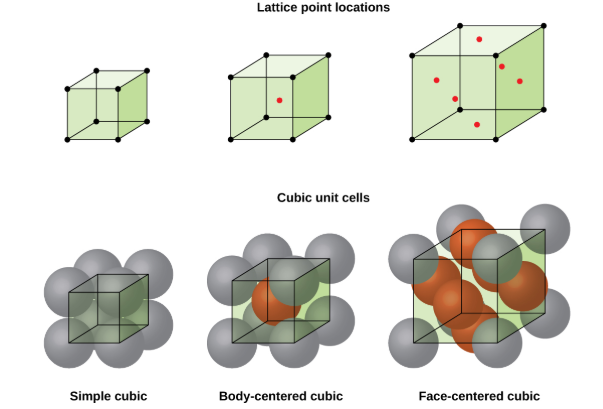
</div>

[1]: https://opentextbc.ca/chemistry/chapter/10-6-lattice-structures-in-crystalline-solids/
[2]: https://depts.washington.edu/matseed/mse_resources/Webpage/Metals/metalstructure.htm
[3]: https://chemed.chem.purdue.edu/genchem/topicreview/bp/ch13/structure.php
[5]: https://www.nde-ed.org/EducationResources/CommunityCollege/Materials/Structure/fcc_hcp.htm#:~:text=The%20difference%20between%20the%20fcc,with%20an%20alternating%20ABAB%20arrangement

To determine the maximum bond length, set the ```maximum_CN``` variable to the coordination number for the studied metal (12 for Gold or other FCC/HCP metals)


In [6]:
%%time

length_precision = 0.001
maximum_CN = 12

def find_maximum_bond_length(points):
    minimum_bond_length = 0
    maximum_bond_length = 4
    while maximum_bond_length-minimum_bond_length > length_precision:
        bond_length_to_test = (maximum_bond_length + minimum_bond_length)/2.0
        n_list = neighbour_list(points, bond_length_to_test)
        max_number_of_neighbours = 0
        for point in n_list:
            max_number_of_neighbours = max(len(point),max_number_of_neighbours)
        if(max_number_of_neighbours<=maximum_CN):
            minimum_bond_length = bond_length_to_test
        else:
            maximum_bond_length = bond_length_to_test
    return minimum_bond_length


# Function testing:

# Variables
particle_to_test = nanoparticle_folders[0]
minimum_bond_length_to_test = 2
maximum_bond_length_to_test = 4

# Open file and read header
nanoparticle_file = open(data_directory+particle_to_test+'/geo.out.xyz', 'r')
N = int(nanoparticle_file.readline())
nanoparticle_file.readline()

# Read locations of atoms from nanoparticle file
atoms=pd.read_csv(nanoparticle_file, header=None, delimiter=r"\s+")
points=atoms.to_numpy()[:,1:4]

print("Maximum bond length with at most "+str(maximum_CN)+" bonds is "+str(find_maximum_bond_length(points))+"Å")

Maximum bond length with at most 12 bonds is 3.09765625Å
Wall time: 2.39 s


# Determining points on surface of point cloud

Three different methods for determining which points are on the surface of a dense point cloud (In this case the atoms in the nanoparticle) have been implemented, namely a convex hull, number of neighbours, and alpha shape (sometimes referred to as a concave hull).

### Convex Hull


Example usage:
```python
points_on_surface(points, "convex_hull")
```

### Number of Neighbours

Example usage:
```python
points_on_surface(points, "number_of_neighbours", neighbour_list=n_list, num_neighbours_internal=8)
```

### Alpha Shape (Concave Hull)

Example usage:
```python
points_on_surface(points, "alpha_shape", alpha=3)
```

In [7]:
# Function to find indexes of particles in the outer shell of the nanoparticle
# Search_type defines whether a convex_hull or number_of_neighbours is used to determine which particles are in the outer shell
def points_on_surface(points, search_type, neighbour_list=None, num_neighbours_internal=None, alpha=None):
    if search_type=='convex_hull':
        return ConvexHull(points).vertices
    if search_type=='number_of_neighbours':
        shell = []
        for i in range(points.shape[0]):
            if len(neighbour_list[i])<num_neighbours_internal:
                shell.append(i)
        return shell
    if search_type=='alpha_shape':
        # Following code modified from answer by Geun (https://stackoverflow.com/questions/26303878/alpha-shapes-in-3d)
        points = points.astype('float64') 
        tetra = Delaunay(points)
        # Find radius of the circumsphere.
        # By definition, radius of the sphere fitting inside the tetrahedral needs 
        # to be smaller than alpha value
        # http://mathworld.wolfram.com/Circumsphere.html
        tetrapos = np.take(points,tetra.vertices,axis=0)
        normsq = np.sum(tetrapos**2,axis=2)[:,:,None]
        ones = np.ones((tetrapos.shape[0],tetrapos.shape[1],1))
        a = np.linalg.det(np.concatenate((tetrapos,ones),axis=2))
        Dx = np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[1,2]],ones),axis=2))
        Dy = np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[0,2]],ones),axis=2))
        Dz = np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[0,1]],ones),axis=2))
        c = np.linalg.det(np.concatenate((normsq,tetrapos),axis=2))
        r = np.sqrt(Dx**2+Dy**2+Dz**2-4*a*c)/(2*np.abs(a))

        # Find tetrahedrals
        tetras = tetra.vertices[r<alpha,:]
        # triangles
        TriComb = np.array([(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)])
        Triangles = tetras[:,TriComb].reshape(-1,3)
        Triangles = np.sort(Triangles,axis=1)
        # Remove triangles that occurs twice, because they are internal
        TrianglesDict = defaultdict(int)
        for tri in Triangles:TrianglesDict[tuple(tri)] += 1
        Triangles=np.array([tri for tri in TrianglesDict if TrianglesDict[tri] ==1])
        Vertices = np.unique(np.concatenate(Triangles))
        return Vertices
    else:
        raise Exception("Invalid search type: "+search_type)

# Feature Extraction



Choose which column's to output by adjusting the ```columns_to_output``` list

In [8]:
%%time
# %matplotlib notebook

# Variables

columns_to_output = ['R', 'CN', 'SCN', 'ABL', 'BL', 'SBL', 'ABA', 'BA', 'SBA']

origin = [0, 0, 0]

# Open csv output file and write header
output_file = open(output_filename, 'w', newline='')
csv_writer = csv.writer(output_file)
output_header = ['ID', 'N_total', 'N_shell/N_total']
for column in columns_to_output:
    output_header += [column+'_min', column+'_max', column+'_avg', column+'_std', column+'_skew', column+'_kurt']
output_header += ['Classical_E', 'Classical_E/N', 'Mermin_E', 'Delta_E', 'Delta_E/N', 'Fermi_L', 'CLASS'] #'N_small_bonds'
# output_header += ['BL_min_'+str(i) for i in range(2, 11)]
csv_writer.writerow(output_header)


for nanoparticle_folder in nanoparticle_folders:
    nanoparticle_filename = data_directory+nanoparticle_folder
    print(nanoparticle_filename)
    try:
        
        nanoparticle_file = open(nanoparticle_filename+'/geo.out.xyz', 'r')

        N = int(nanoparticle_file.readline())
        nanoparticle_file.readline()

        atoms=pd.read_csv(nanoparticle_file, header=None, delimiter=r"\s+")
        points=atoms.to_numpy()[:,1:4]

        # Normalise atoms in the nanoparticle to be centered (By center of mass) at the origin
        for i in [0,1,2]:
            points[:,i]-=statistics.mean(points[:,i])
        
        maximum_bond_length = find_maximum_bond_length(points)
        n_list = neighbour_list(points, maximum_bond_length)
        
        # Find atom's in shell and their distance from the origin (radius)
        shell = points_on_surface(points, 'alpha_shape', alpha=2.9)
        shell_points = points[shell]
        shell_radius=[]
        for point in shell_points:
            shell_radius.append(find_point_distance(point, origin))
        
        # Find atomic coordination numbers and bond lengths
        atomic_coordination_numbers = []
        surface_coordination_numbers = []
        average_bond_lengths = []
        bond_lengths = []
        surface_bond_lengths = []
        for point in range(len(n_list)):
            atomic_coordination_numbers.append(len(n_list[point]))
            if point in shell:
                surface_coordination_numbers.append(len(n_list[point]))
            temp_bond_lengths=[]
            for point2 in n_list[point]:
                bond_length=find_point_distance(points[point], points[point2])
                temp_bond_lengths.append(bond_length)
                if(point < point2):
                    bond_lengths.append(bond_length)
                    if point in shell or point2 in shell:
                        surface_bond_lengths.append(bond_length)
            if(len(temp_bond_lengths)>0):
                average_bond_lengths.append(statistics.mean(temp_bond_lengths))
            else:
                print("Error: Atom with no bonds")
        
        
#         plt.hist(bond_lengths, bins=50)
#         plt.show()

        # Find bond angles
        average_bond_angles = []
        bond_angles = []
        surface_bond_angles = []
        for point in range(len(n_list)):
            temp_bond_angles = []
            for neighbour1 in range(len(n_list[point])-1):
                for neighbour2 in range(neighbour1+1, len(n_list[point])):
                    bond_angle = find_angle(points[point], points[n_list[point][neighbour1]], points[n_list[point][neighbour2]])
                    temp_bond_angles.append(bond_angle)
                    bond_angles.append(bond_angle)
                    if point in shell:
                        surface_bond_angles.append(bond_angle)
            if(len(temp_bond_angles)>0):
                average_bond_angles.append(statistics.mean(temp_bond_angles))
                      
                
#         plt.hist(bond_angles, bins=50)
#         plt.show()
                
        # Extract classical energy from LAMMPS simulation
        classical_energy = LAMMPS_data.loc[LAMMPS_data["ID"] == int(nanoparticle_folder)].iloc[0]['Classical_E']
        CLASS = str(int(LAMMPS_data.loc[LAMMPS_data["ID"] == int(nanoparticle_folder)].iloc[0]['CLASS']))
        
        # Extract Mermin energy from DFTB+ simulation
        DFTB_text = open(nanoparticle_filename+'/'+DFTB_input_filename, 'r').read()
        match = re.search(r'Total Mermin free energy: *[-+]?\d*\.\d* *H *([-+]?\d*\.\d*) eV', DFTB_text)
        mermin_energy = 0.0
        if match:
            mermin_energy = float(match.group(1))
        else:
            print('Error: Could not extract mermin energy from DFTB+ simulation')
        mermin_energy -= N*(-74.6651)
        
        energy_difference = mermin_energy-classical_energy
        
        # Extract Fermi level from DFTB+ simulation
        match = re.search(r'Fermi level: *[-+]?\d*\.\d* *H *([-+]?\d*\.\d*) eV', DFTB_text)
        fermi_level = 0.0
        if match:
            fermi_level = float(match.group(1))
        else:
            print('Error: Could not extract fermi level from DFTB+ simulation')

#         print(classical_energy, mermin_energy, energy_difference, energy_correction, energy_difference-energy_correction)
            
        feature_name_map = {
            'R': shell_radius,
            'CN': atomic_coordination_numbers,
            'SCN': surface_coordination_numbers,
            'ABL': average_bond_lengths,
            'BL': bond_lengths,
            'SBL': surface_bond_lengths,
            'ABA': average_bond_angles,
            'BA': bond_angles,
            'SBA': surface_bond_angles
        }
        
        bond_lengths.sort()
#         small_bonds = bond_lengths[1:10]
        
    
        row_to_output = [nanoparticle_folder, N, len(shell_points)/N]
        for column in columns_to_output:
            feature = feature_name_map[column]
            row_to_output += [min(feature), max(feature), statistics.mean(feature), statistics.stdev(feature), scipy.stats.skew(feature), scipy.stats.kurtosis(feature)]
        row_to_output+=[classical_energy, classical_energy/N, mermin_energy, energy_difference, energy_difference/N, fermi_level, CLASS] # n_small
#         row_to_output+=small_bonds
        csv_writer.writerow(row_to_output)
        
#         fig = plt.figure()
#         ax = fig.add_subplot(111, projection='3d')
#         plt.plot(points[:,0], points[:,1], points[:,2], 'b.')
#         plt.plot(points[shell,0], points[shell,1], points[shell,2], 'r.')
#         plt.show()

    except FileNotFoundError:
        print("No such file or directory: "+nanoparticle_filename+'/geo.out.xyz')
        
#     break
        
output_file.close()

print("Done")
    

../data/LAMMPS-DFTB-GOLD/000062
../data/LAMMPS-DFTB-GOLD/000071
../data/LAMMPS-DFTB-GOLD/000072
../data/LAMMPS-DFTB-GOLD/000073
../data/LAMMPS-DFTB-GOLD/000081
../data/LAMMPS-DFTB-GOLD/000082
../data/LAMMPS-DFTB-GOLD/000083
../data/LAMMPS-DFTB-GOLD/000091
../data/LAMMPS-DFTB-GOLD/000092
../data/LAMMPS-DFTB-GOLD/000093
../data/LAMMPS-DFTB-GOLD/000094
../data/LAMMPS-DFTB-GOLD/000171
../data/LAMMPS-DFTB-GOLD/000172
../data/LAMMPS-DFTB-GOLD/000182
../data/LAMMPS-DFTB-GOLD/000183
../data/LAMMPS-DFTB-GOLD/000191
../data/LAMMPS-DFTB-GOLD/000194
../data/LAMMPS-DFTB-GOLD/000201
../data/LAMMPS-DFTB-GOLD/000202
../data/LAMMPS-DFTB-GOLD/000203
../data/LAMMPS-DFTB-GOLD/000204
../data/LAMMPS-DFTB-GOLD/000205
../data/LAMMPS-DFTB-GOLD/000206
../data/LAMMPS-DFTB-GOLD/000207
../data/LAMMPS-DFTB-GOLD/000208
../data/LAMMPS-DFTB-GOLD/000209
../data/LAMMPS-DFTB-GOLD/000210
../data/LAMMPS-DFTB-GOLD/000211
../data/LAMMPS-DFTB-GOLD/000212
../data/LAMMPS-DFTB-GOLD/000213
../data/LAMMPS-DFTB-GOLD/000214
../data/

../data/LAMMPS-DFTB-GOLD/002993
../data/LAMMPS-DFTB-GOLD/002994
../data/LAMMPS-DFTB-GOLD/003071
../data/LAMMPS-DFTB-GOLD/003072
../data/LAMMPS-DFTB-GOLD/003081
../data/LAMMPS-DFTB-GOLD/003082
../data/LAMMPS-DFTB-GOLD/003091
../data/LAMMPS-DFTB-GOLD/003093
../data/LAMMPS-DFTB-GOLD/003173
../data/LAMMPS-DFTB-GOLD/003182
../data/LAMMPS-DFTB-GOLD/003184
../data/LAMMPS-DFTB-GOLD/003191
../data/LAMMPS-DFTB-GOLD/003192
../data/LAMMPS-DFTB-GOLD/003871
../data/LAMMPS-DFTB-GOLD/003873
../data/LAMMPS-DFTB-GOLD/003881
../data/LAMMPS-DFTB-GOLD/003882
../data/LAMMPS-DFTB-GOLD/003884
../data/LAMMPS-DFTB-GOLD/003891
../data/LAMMPS-DFTB-GOLD/003892
../data/LAMMPS-DFTB-GOLD/003893
../data/LAMMPS-DFTB-GOLD/003894
../data/LAMMPS-DFTB-GOLD/003983
../data/LAMMPS-DFTB-GOLD/003984
../data/LAMMPS-DFTB-GOLD/003991
../data/LAMMPS-DFTB-GOLD/003992
../data/LAMMPS-DFTB-GOLD/003993
../data/LAMMPS-DFTB-GOLD/AuNP+
No such file or directory: ../data/LAMMPS-DFTB-GOLD/AuNP+/geo.out.xyz
../data/LAMMPS-DFTB-GOLD/AuNP-
No s